Part of the code is based on the Madry Lab's robustness toolkit and Google DeepDream. You can check out more here https://github.com/MadryLab
and here https://distill.pub/2017/feature-visualization/


**Note:** To speed up the execution of the experiments, we recommend using GPU acceleration. If you are running the notebook on Colab, select GPU as your runtime type as follows: Runtime → Change runtime type → Hardware accelerator → GPU → Save.

In [ ]:
# staring pset3

In [3]:
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm_notebook as tqdm
import numpy as np
import torchvision.models as models
import cv2
import torchvision.transforms as transforms
cuda_available = torch.cuda.is_available()
mps_available = torch.backends.mps.is_available()
# For reproducibility
torch.manual_seed(1234)

In [4]:
import requests
def download(url, fn=None):
  if fn is None:
    fn = url.split('/')[-1]
  r = requests.get(url)
  if r.status_code == 200:
      open(fn, 'wb').write(r.content)
      print("{} downloaded: {:.2f} KB".format(fn, len(r.content)/1024.))
  else:
      print("url not found:", url)

Download the test image and classes.

In [7]:
download('http://6.869.csail.mit.edu/fa19/psets19/pset6/imagenet_classes.txt')
download('http://6.869.csail.mit.edu/fa19/psets19/pset6/WelshCorgi.jpeg')

imagenet_classes.txt downloaded: 21.17 KB
WelshCorgi.jpeg downloaded: 127.39 KB




# Neural Network Inference (Problem 2)

In this exercise, you will be playing with a convolutional neural network to classify images into semantic labels. You will be working with ResNet50, a variant of the residual convolutional network architecture. We will be testing the network to classify an image into one of the 1000 ImageNet categories.

### Load ImageNet class names


In [5]:
with open('imagenet_classes.txt', 'r') as f:
  imagenet_classes = f.readlines()
  imagenet_classes_short = [x.strip().split(',')[-1] for x in imagenet_classes]

print('Imagenet classes')
for it, class_name in enumerate(imagenet_classes):
  if it == 3:
    print('...')
  elif it < 4 or it > 997:
    print('{}. {}'.format(it, class_name))

Imagenet classes
0. tench, Tinca tinca

1. goldfish, Carassius auratus

2. great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias

...
998. ear, spike, capitulum

999. toilet tissue, toilet paper, bathroom tissue


## Running a randomly initialized network
We will start by using a randomly initalized ResNet50 to perform classification.

### Load a randomly initalized network (Problem 2a)

In [6]:
# Download ResNet50 from Pytorch repository
arch = 'resnet50'
model = models.__dict__[arch]()
# We set it in eval, so that batch normalization layers are not updated
model.eval();
if cuda_available:
  model.cuda()
if mps_available:
  model.to('mps')

In [7]:
# Visualize the last layer
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

### Preparing the image for inference

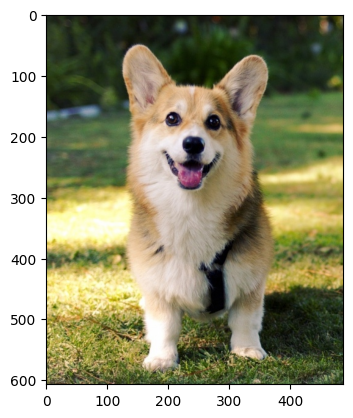

In [8]:
# Load the image we will be playing with
img = cv2.imread('WelshCorgi.jpeg')
plt.imshow(img[:, :, ::-1])

In [26]:
# In order to run the image through a model, we need to prepare it first.
# This includes:
# 1. Resizing the image to an appropiate size for the network.
# 2. Converting the image to a tensor - this will normalize the image in the
#    0-1 range and change the channel order.
# 3. Normalizing the image.
# 4. Puting the image in a batch. In our case, we will use a single element
#    batch.

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def prepare_image(image_cv2, do_normalize=True):
  # Resize
  img = cv2.resize(image_cv2, (224, 224))
  img = img[:, :, ::-1].copy()
  # Convert to tensor
  tensor_img = transforms.functional.to_tensor(img)

  # Possibly normalize
  if do_normalize:
    tensor_img = normalize(tensor_img)
  # Put image in a batch
  batch_tensor_img = torch.unsqueeze(tensor_img, 0)

  # Put the image on the GPU
  if cuda_available:
    batch_tensor_img = batch_tensor_img.cuda()
  if mps_available:
    batch_tensor_img = batch_tensor_img.to('mps')
  return batch_tensor_img


def UnNormalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]):
  std_arr = torch.tensor(std)[:, None, None]
  mean_arr = torch.tensor(mean)[:, None, None]
  mean_arr = mean_arr.to('mps')
  std_arr = std_arr.to('mps')
  def func(img):
    img = img.clone()
    img *= std_arr
    img += mean_arr
    return img
  return func
unnormalize = UnNormalize()

def obtain_image(tensor_img, do_normalize=True):
  if cuda_available:
    tensor_img = tensor_img.cpu()
  if mps_available:
    tensor_img = tensor_img.to('mps')
  if do_normalize:
    tensor_img = unnormalize(tensor_img)
  img = transforms.functional.to_pil_image((tensor_img.data))
  return img

### Classifying the image (Problem 2b)

This architecture outputs a vector of 1000 elements, that correspond to the class logits: each of the class probabilities before doing a softmax.

In [10]:
# Prepare the image
batch_normalized_img = prepare_image(img)
# Run it through the network
output = model(batch_normalized_img)

Let's visualize the top classes

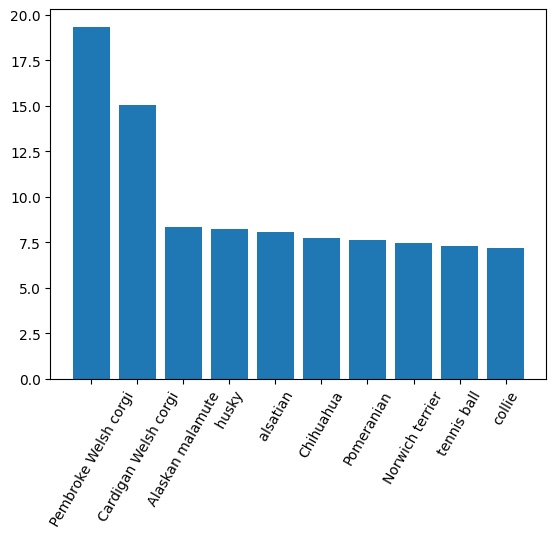

In [17]:
def plot_top_classes(values, top_k=10):
  sorted_classes = np.argsort(-values)
  class_ids = sorted_classes[:top_k]
  class_names = [imagenet_classes_short[it] for it in list(class_ids)]
  class_values = values[class_ids]
  plt.bar(class_names, class_values)
  plt.xticks(rotation=60)


plot_top_classes(output[0,:].data.cpu().numpy())

### Load and run a pre-trained network (Problem 2c)

Unsurprisingly, the network predictions above have nothing to do with the image, since the network was intialized from scratch. Instead, we will initialize the network with pre-trained weights (from a neural network that has been trained on the ImageNet dataset).

In [18]:
arch = 'resnet50'
model = models.__dict__[arch](pretrained=True)
model.eval();
# model.cuda();
model.to('mps')

/Users/suhrid.deshmukh/.pyenv/versions/vision_psets/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/suhrid.deshmukh/.pyenv/versions/vision_psets/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

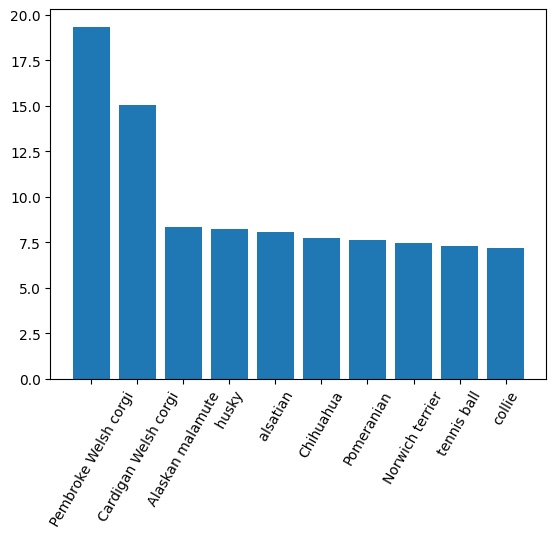

In [19]:
# output = model(batch_normalized_img.cuda())
output = model(batch_normalized_img.to('mps'))
plot_top_classes(output[0,:].data.cpu().numpy())
# plot_top_classes(output[0,:].data.cuda().numpy())

The top predictions seem to make much more sense now. But it is not clear how to interpret the logits (the raw output scalars). Please normalize the logits into the probability range using the `torch.nn.functional.softmax` function (TODO1).  

In [14]:
def output2prob(output):
  ### TODO1
  # Your code here:
  prob = torch.nn.functional.softmax(output, dim=-1)
  ###
  return prob



Now rerun the network, passing the output through our `output2prob` function:

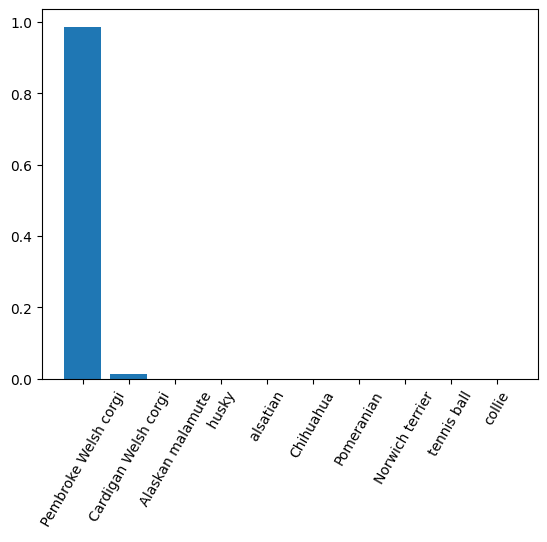

In [20]:
output = model(batch_normalized_img.to('mps'))
prob = output2prob(output)
plot_top_classes(prob[0,:].data.cpu().numpy())

# Adversarial Examples (Problem 4)

Although the above results show that deep neural networks can classify the image correctly as *corgi*, it is actually not robust! In this section, we are going to show that neural networks can be "fooled" when some unperceivable noises are added to the image.

Here's an example:

<img src="https://miro.medium.com/max/4000/1*PmCgcjO3sr3CPPaCpy5Fgw.png" alt="drawing" width="600"/>

Note that the left and right images look the same to the human eyes, but result in very different neural network predictions. Since the right image can pose security threats to our model, we call these images **adversarial examples**.

How can we create adversarial examples? Remember that when training a neural network, we use backpropagation to obtain the gradient of the loss with respect to the network parameters, and use it to update the the parameters that minimize the loss.

We can also use backpropagation to obtain the gradient of the loss with respect to the input image, given the network parameters. If we update the image according to that gradient, we can generate images that maximize certain activations, or minimize the loss. If properly applied, small changes in an image can completely change the neural network's prediction and result in adversarial examples.



Let's try to fool the neural network!

## Attack 1 (Problem 4a)
We will use the following function to generate the adversarial examples. This function will take as input 1) the neural network model and 2) the normal image and output an adversarial example, a modified image that looks similar to the normal image but fools the neural network.

In [21]:
def generate_adversarial_example(model_fn, x, class_id, n_iter=200, alpha=0.01):
  """
  :param model_fn: a callable that takes an input tensor and returns the model logits.
  :param x: input tensor.
  :param class_id: the id of the target class.
  :return: a tensor for the adversarial example
  """
  for i in tqdm(range(n_iter)):
    ### TODO2
    # You should:
    # 1. Run input image/tensor x through the model to obtain the raw, unnormalized logits.
    # 2. Define a loss or objective that maximizes the log probability of the target class.
    # (Note - You can consider using off-the-shelf loss functions in torch that directly take
    #  logits as input OR define your own function to compute log probabilities from logits)
    # 3. Compute the gradient of the objective with respect to x using
    #    torch.autograd.grad
    #
    # Your code here:
    logit = model_fn(x)
    loss = -torch.nn.functional.cross_entropy(logit, torch.tensor([class_id]).to('mps'))
    gradient, = torch.autograd.grad(loss, x)[0]
    ###
    # x = step.step(x, -1*gradient)
    x = x + alpha * gradient.sign()
  return x

In [22]:
import torch
from tqdm import tqdm

def generate_adversarial_example(model_fn, x, class_id, n_iter=200, alpha=0.01):
    """
    Generates an adversarial example by modifying x to maximize the probability of target class.

    :param model_fn: A callable function that takes an input tensor and returns model logits.
    :param x: Input tensor (image).
    :param class_id: Target class ID (the class we want the model to misclassify as).
    :param n_iter: Number of optimization steps (default = 200).
    :param alpha: Step size for perturbation (default = 0.01).
    :return: The adversarial image tensor.
    """

    # Ensure input requires gradient
    x = x.clone().detach().requires_grad_(True)

    for i in tqdm(range(n_iter)):
        # Forward pass - Get raw logits from the model
        logits = model_fn(x)  # Logits are unnormalized scores for each class

        # Define the loss: maximize the log probability of the target class
        loss = -torch.nn.functional.cross_entropy(logits, torch.tensor([class_id], device=x.device))

        # Compute gradient of loss w.r.t. input image
        gradient = torch.autograd.grad(loss, x)[0]

        # Update the image in the direction that increases target class probability
        x = x + alpha * gradient.sign()

        # Keep image values within valid range [0, 1] (assuming normalized inputs)
        x = torch.clamp(x, 0, 1)

    return x.detach()  # Return adversarial example


### Step class
We will use the following class to generate our image. This class will take a tensor x corresponding to the image a g corresponding to the gradient and will update x according to g. To ensure that the updated image lies in a reasonable manifold, we will also allow for a projection.

In [23]:
class StepImage():
  def __init__(self, orig_input, step_size=2, is_normalized=True,
               renorm=True, eps=30, norm_update='l2'):
    self.orig_input = orig_input
    if is_normalized:
      mean=[0.485, 0.456, 0.406]
      std= [0.229, 0.224, 0.225]
    else:
      mean=[0., 0., 0.]
      std= [1., 1., 1.]

    is_cuda = orig_input.is_cuda
    self.mean = torch.tensor(mean)[:, None, None]
    self.std = torch.tensor(std)[:, None, None]
    if is_cuda:
      self.mean = self.mean.cuda()
      self.std = self.std.cuda()
    self.eps = eps
    self.renorm = renorm
    self.step_size = step_size
    self.norm_update = norm_update

  def project(self, x):
    """
    """
    diff = x - self.orig_input
    if self.renorm:
      diff = diff.renorm(p=2, dim=0, maxnorm=self.eps)
    val_projected = self.orig_input + diff

    val_projected *= self.std
    val_projected += self.mean
    val_clamped = torch.clamp(val_projected, 0, 1)
    val_clamped -= self.mean
    val_clamped /= self.std
    return val_clamped

  def step(self, x, g):
    step_size = self.step_size
    # Scale g so that each element of the batch is at least norm 1
    if self.norm_update == 'l2':
      l = len(x.shape) - 1
      g_norm = torch.norm(g.view(g.shape[0], -1), dim=1).view(-1, *([1]*l))
    else:
      g_norm = torch.torch.abs(g).mean()
    scaled_g = g / (g_norm + 1e-10)
    stepped = x + scaled_g * step_size
    projected = self.project(stepped)
    return projected

### Attack 1

We will now update the image to make the model think this image is a **Tarantula (id 76)**.

In [24]:
img = cv2.imread('WelshCorgi.jpeg')
starting_image = prepare_image(img)

# This allows to backpropagate the image
batch_tensor = starting_image.clone().requires_grad_(True)

# This updates the image according to some gradient
step = StepImage(starting_image, step_size=3, renorm=True)
batch_tensor = generate_adversarial_example(model, batch_tensor, 76)
print(torch.norm(batch_tensor - starting_image, 0))

100%|██████████| 200/200 [00:02<00:00, 73.54it/s]


tensor(148919., device='mps:0')


### Visualize the original and attacked images

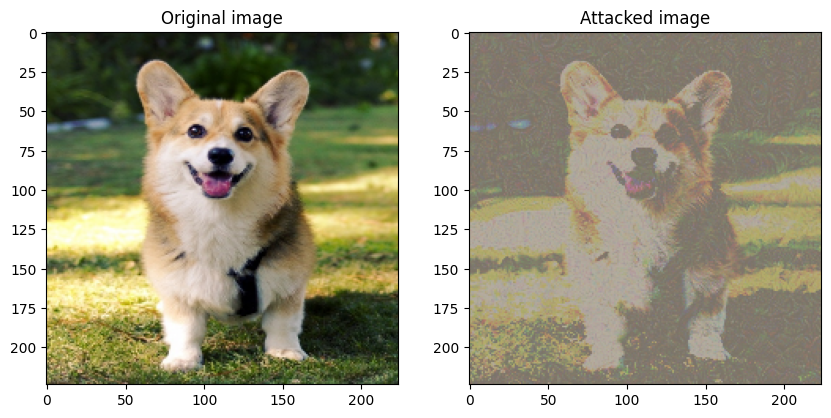

In [27]:
original_image = obtain_image(starting_image[0, :], do_normalize=True)
attacked_image_tarantula = obtain_image(batch_tensor[0, :], do_normalize=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original image')
axs[0].imshow(original_image)
axs[1].set_title('Attacked image')
axs[1].imshow(attacked_image_tarantula)

### Compute the updated probabilities



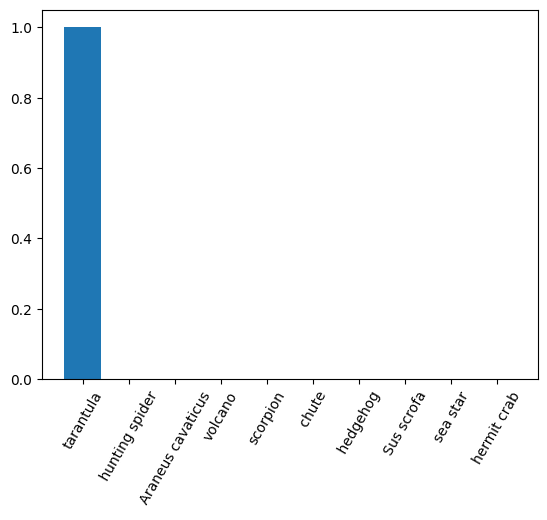

In [28]:
output = model(batch_tensor)
prob = output2prob(output)
plot_top_classes(prob[0,:].data.cpu().numpy())

## Attack 2 (Problem 4b)

We will now update the image to make the model think this image is a **Tiger Cat (id 282)**.

In [29]:
model.eval()
starting_image = prepare_image(img)
batch_tensor = starting_image.clone()
batch_tensor.requires_grad_(True)
step = StepImage(starting_image, step_size=3, renorm=True)
batch_tensor = generate_adversarial_example(model, batch_tensor, 282)
print(torch.norm(batch_tensor - starting_image, 0))

100%|██████████| 200/200 [00:02<00:00, 78.15it/s]

tensor(148940., device='mps:0')


### Visualize the original and attacked images

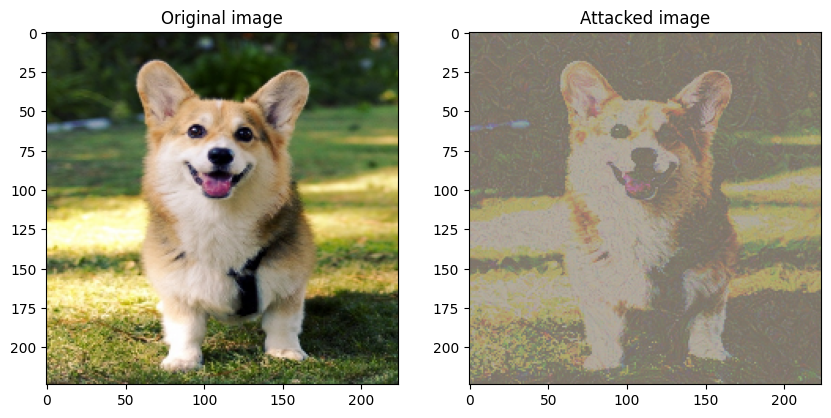

In [30]:
original_image = obtain_image(starting_image[0, :], do_normalize=True)
attacked_image_siamese = obtain_image(batch_tensor[0, :], do_normalize=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original image')
axs[0].imshow(original_image)
axs[1].set_title('Attacked image')
axs[1].imshow(attacked_image_siamese)

### Compute the updated probabilities


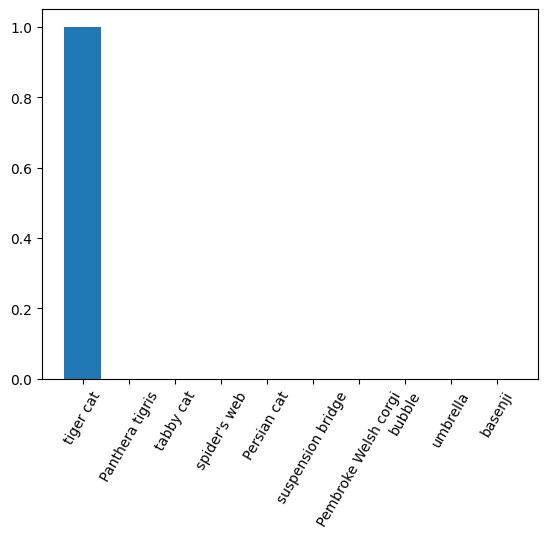

In [31]:
output = model(batch_tensor)
prob = output2prob(output)
plot_top_classes(prob[0,:].data.cpu().numpy())

## Comparing Images (Problem 4c)



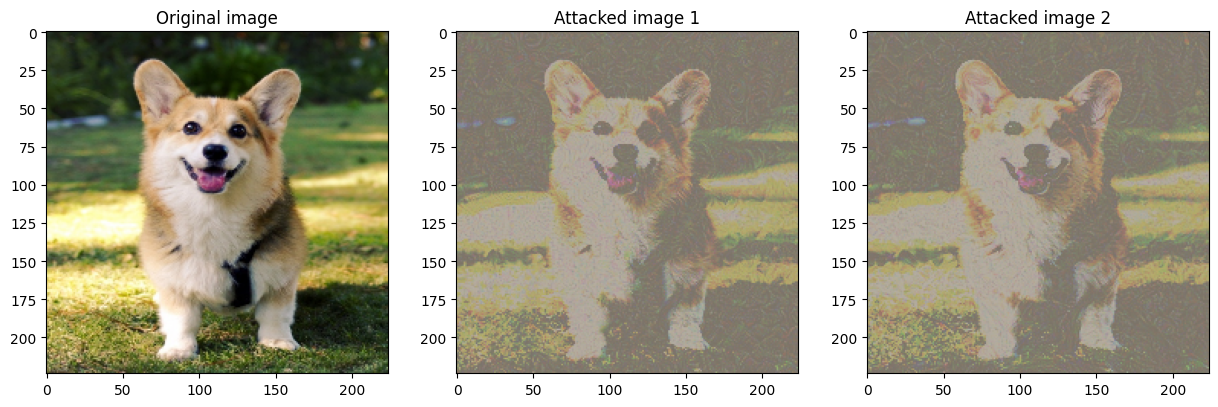

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('Original image')
axs[0].imshow(original_image)
axs[1].set_title('Attacked image 1')
axs[1].imshow(attacked_image_tarantula)
axs[2].set_title('Attacked image 2')
axs[2].imshow(attacked_image_siamese)

## Maximizing layers (Problem 4d) [6.8300 only]


In [ ]:
# This function creates a function that gives the output of a given
# network at layer: layer_id.
# Usage:
# model_l = model_layer(model, layer_id_interest)
# output_layer_interest = model_l(input)
def model_layer(model, layer_id):
  layers = [model.layer1, model.layer2, model.layer3, model.layer4]
  def forward(input):
    layers_used = layers[:(layer_id+1)]
    x = input
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    for l in layers_used:
      x = l(x)
    return x
  return forward

In [ ]:
for param in model.parameters():
    param.requires_grad = False

starting_image = torch.rand((1, 3, 224, 224))
if cuda_available: starting_image = starting_image.cuda()
batch_tensor = starting_image.clone().requires_grad_(True)
step = StepImage(starting_image, step_size=0.05, renorm=False, norm_update='abs', is_normalized=False)

### TODO3
# Modify Layer ID (0-3) to select feature from different layers
layer_id =
###
model_l = model_layer(model, layer_id)

# target image and the embedding
target_image = prepare_image(img)
target_feat = model_l(target_image)

for _ in tqdm(range(200)):
  feat = model_l(batch_tensor)
  ### TODO4
  # You should minimize the L2 norm between feat and target_feat
  # Your code here:
  loss =
  ###
  gradient, = torch.autograd.grad(loss, batch_tensor)
  batch_tensor = step.step(batch_tensor, -gradient)

In [ ]:
original_image = obtain_image(starting_image[0, :], do_normalize=False)
modified_image = obtain_image(batch_tensor[0, :], do_normalize=False)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original random image')
axs[0].imshow(original_image)
axs[1].set_title('Modified image')
axs[1].imshow(modified_image)

## Robust model (Problem 4e)

The property shown above is clearly not desirable. Creating such adversaries would allow to fool networks without humans noticing it, which could cause security issues. To address this, some researchers have proposed methods \[1\] for training robust models! Let's see what will happen if we attack the robust models:

\[1\] [Image Synthesis with a Single (Robust) Classifier](https://arxiv.org/pdf/1906.09453.pdf), Santurkar et al.

### Download the robustly trained model and load it

In [ ]:
download('http://6.869.csail.mit.edu/fa19/psets19/pset6/imagenet_l2_3_0.pt')

In [ ]:
if cuda_available:
  model_weights = torch.load('imagenet_l2_3_0.pt')
else:
  model_weights = torch.load('imagenet_l2_3_0.pt', map_location=torch.device('cpu'))
model_weights_modified = {name.split('model.')[1]: value for name, value in model_weights['model'].items() if 'model' in name}
model.load_state_dict(model_weights_modified)

Here we show that the input image is modified when maximizing the class **Tiger Cat** (id 282).

In [ ]:
model.eval()
for param in model.parameters():
    param.requires_grad = False
initial_image = prepare_image(img, do_normalize=False)
batch_tensor = initial_image.clone()
batch_tensor.requires_grad_(True)
step = StepImage(initial_image, step_size=2, renorm=True, is_normalized=False, eps=30)
batch_tensor = generate_adversarial_example(model, batch_tensor, 282)

In [ ]:
image = obtain_image(initial_image[0, :], do_normalize=False)
plt.imshow(image)
plt.figure()
image = obtain_image(batch_tensor[0, :], do_normalize=False)
plt.imshow(image)

### Compute the updated log-probabilities

In [ ]:
output = model(batch_tensor)
prob = output2prob(output)
plot_top_classes(prob[0,:].cpu().data.numpy())

## Repeat Problem 4d using the robust model (Problem 4f)

The robust model can also change the resulting image when trying to infer the input from the embedding. Repeat all the procedure in question 4.d with the robust model. Does the result look different?

In [ ]:
for param in model.parameters():
    param.requires_grad = False

starting_image = torch.rand((1, 3, 224, 224))
if cuda_available: starting_image = starting_image.cuda()
batch_tensor = starting_image.clone().requires_grad_(True)
step = StepImage(starting_image, step_size=0.05, renorm=False, norm_update='abs', is_normalized=False)


### TODO5
# Modify Layer ID (0-3) to select feature from different layers
layer_id =
###
model_l = model_layer(model, layer_id)

# target image
target_image = prepare_image(img)
target_feat = model_l(target_image)

for _ in tqdm(range(200)):
  feat = model_l(batch_tensor)
  ### TODO6
  # You should minimize the L2 norm between feat and target_feat
  # Your code here:
  loss =
  ###
  gradient, = torch.autograd.grad(loss, batch_tensor)
  batch_tensor = step.step(batch_tensor, -gradient)

original_image = obtain_image(starting_image[0, :], do_normalize=False)
modified_image = obtain_image(batch_tensor[0, :], do_normalize=False)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Original random image')
axs[0].imshow(original_image)
axs[1].set_title('Modified image')
axs[1].imshow(modified_image)